# Тема 3. Задача классификации, дерево решений и метод ближайших соседей

Классическое, общее определение машинного обучения звучит так: "говорят, что компьютерная программа *обучается* при решении какой-то задачи из класса T, если ее производительность, согласно метрике P, улучшается  при накоплении опыта E".

Далее в разных сценариях под *T, P*,  и *E* подразумеваются совершенно разные вещи. Среди самых популярных задач *T* в машинном обучении:
 - классификация – отнесение объекта к одной из категорий на основании его признаков 
 - регрессия – прогнозирование количественного признака объекта на основании прочих его признаков 
 - кластеризация – разбиение множества объектов на группы на основании признаков этих объектов так, чтобы внутри групп объекты были похожи между собой, а вне одной группы  – менее похожи
 - детекция аномалий – поиск объектов, "сильно непохожих" на все остальные в выборке либо на какую-то группу объектов
 - и много других, более специфичных.
 
 Под опытом *E* понимаются данные (без них никуда), и в зависимости от этого алгоритмы машинного обучения могут быть поделены на тех, что обучаются *с учителем* и *без учителя* (supervised & unsupervised learning). В задачах обучения без учителя имеется* выборка*, состоящая из *объектов*,  описываемых набором *признаков*.  В задачах обучения с учителем вдобавок к этому для каждого объекта некоторой выборки, называемой *обучающей*, известен *целевой признак* – по сути это то, что хотелось бы прогнозировать для прочих объектов, не из обучающей выборки. 

Третья абстракция в определении машинного обучения – это метрика оценки производительности алгоритма *P*. Такие метрики различаются для разных задач и алгоритмов, и про них мы будим говорить по мере изучения алгоритмов. Пока скажем, что самая простая метрика качества алгоритма, решающего задачу классификации – это доля правильных ответов (*accuracy*, не называйте ее *точностью*, этот перевод зарезервирован под другую метрику, *precision*) – то есть попросту доля верных прогнозов алгоритма на тестовой выборке. 

## Дерево решений 
еревья решений используются в повседневной жизни в самых разных областях человеческой деятельности, порой и очень далеких от машинного обучения. Деревом решений можно назвать наглядную инструкцию, что делать в какой ситуации. Приведем пример из области консультирования научных сотрудников института. Высшая Школа Экономики выпускает инфо-схемы, облегчающие жизнь своим сотрудникам. Вот фрагмент инструкции по публикации научной статьи на портале института.

![img](https://habrastorage.org/files/401/8cd/bea/4018cdbea7a64306be94ed784fce4a06.png)<br>
В терминах машинного обучения можно сказать, что это элементарный классификатор, который определяет форму публикации на портале (книга, статья, глава книги, препринт, публикация в "НИУ ВШЭ и СМИ") по нескольким признакам: типу публикации (монография, брошюра, статья и т.д.), типу издания, где опубликована статья (научный журнал, сборник трудов и т.д.) и остальным.

<img src="https://habrastorage.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif"/><br>

#### Энтропия
Энтропия Шеннона определяется для системы с $N$ возможными состояниями следующим образом:

$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

где  $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Опуская предпосылки введения (комбинаторные и теоретико-информационные) этого понятия, отметим, что, интуитивно, энтропия соответствует степени хаоса в системе. Чем выше энтропия, тем менее упорядочена система и наоборот. Это поможет там формализовать "эффективное разделение выборки", про которое мы говорили в контексте игры "20 вопросов".

<h4>Пример</h4>
Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем тот же игрушечный пример, что в статье <a href="https://habrahabr.ru/post/171759/">"Энтропия и деревья принятия решений"</a>. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$. В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$. Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как 
$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$
где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации получился 
$$\Large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$
Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.  
<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>
Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная. 
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее. 

#### Алгоритм построения дерева

Можно убедиться в том, что построенное в предыдущем примере дерево является в некотором смысле оптимальным – потребовалось только 5 "вопросов" (условий на признак $x$), чтобы "подогнать" дерево решений под обучающую выборку, то есть чтобы дерево правильно классифицировало любой обучающий объект. При других условиях разделения выборки дерево получится глубже. 

В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева. 

```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t     
```

#### Другие критерии качества разбиения в задаче классификации

Мы разобрались, в том, как понятие энтропии позволяет формализовать представление о качестве разбиения в дереве. Но это всего-лишь эвристика, существуют и другие:

 - Неопределенность Джини (Gini impurity):  $G = 1 - \sum\limits_k (p_k)^2$. Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Подробнее об этом (как и обо многом другом) можно узнать из [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова. Не путать с индексом Джини! Подробнее об этой путанице – в [блогпосте](https://alexanderdyakonov.wordpress.com/2015/12/15/%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%8C%D1%82%D0%B5%D1%81%D1%8C-%D0%B4%D0%B6%D0%B8%D0%BD%D0%B8/) Александра Дьяконова
 - Ошибка классификации (misclassification error):  $E = 1 - \max\limits_k p_k$
 
 
На практике ошибка классификации почти не используется, а неопределенность Джини и прирост информации работают почти одинаково.

В случае задачи бинарной классификации ($p_+$ – вероятность объекта иметь метку +) энтропия и неопределенность Джини примут следующий вид:<br><br>
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$$

Когда мы построим графики этух двух функций от аргумента $p_+$, то увидим, что график энтропии очень близок к графику удвоенной неопределенности Джини, и поэтому на практике эти два критерия "работают" почти одинаково.

In [3]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

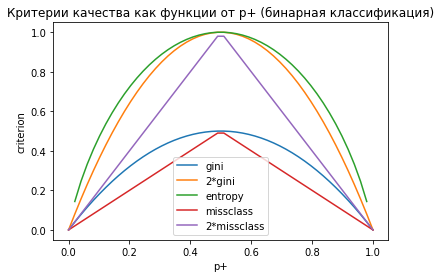

In [14]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1 - x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.legend()
plt.show()

In [15]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации.

In [22]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                      np.arange(y_min, y_max, eps))

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно,  прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то *гладкая* граница, разделяющая 2 класса, или хотя бы просто прямая (в $n$-мерном случае - гиперплоскость). 

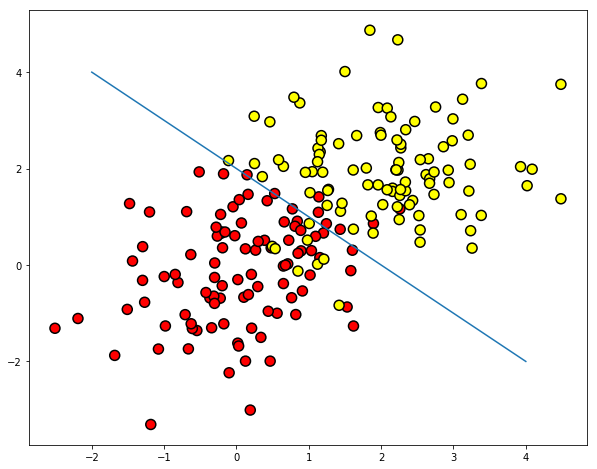

In [23]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.scatter(train_data[:, 0], train_data[:, 1],
           c = train_labels, s=100, cmap='autumn', edgecolors='black',
           linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1))

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр `max_depth`, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.|

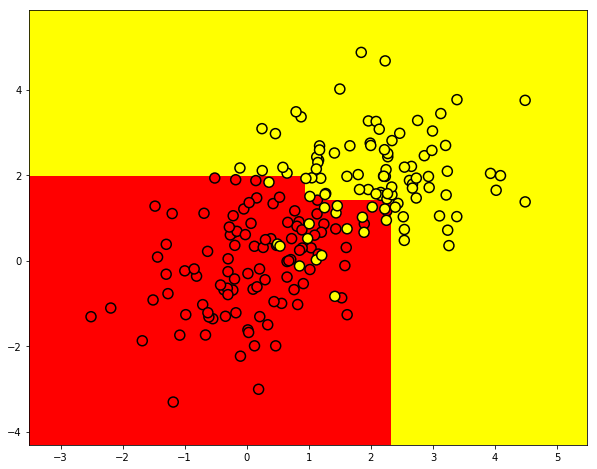

In [25]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем
clf_tree.fit(train_data, train_labels)

xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100,
           cmap='autumn', edgecolors='black', linewidth=1.5)

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

In [36]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33],
                    'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})
data

,Возраст,Невозврат кредита
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [37]:
data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


In [38]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [41]:
data2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})
data2

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


In [42]:
data2.sort_values('Возраст')

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [43]:
data2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [44]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

# Метод ближайших соседей

Метод ближайших соседей (k Nearest Neighbors, или kNN) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотезой компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

Согласно методу ближайших соседей, тестовый пример (зеленый шарик) будет отнесен к классу "синие", а не "красные".

<img src="../../img/topic3_knn_intuition.png">

Например, если не знаешь, какой тип товара указать в объявлении для Bluetooth-гарнитуры, можешь найти 5 похожих гарнитур, и если 4 из них отнесены к категории "Аксессуары", и только один - к категории "Техника", то здравый смысл подскажет для своего объявления тоже указать категорию "Аксессуары".

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
 - Вычислить расстояние до каждого из объектов обучающей выборки
 - Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально
 - Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей
 
 Примечательное свойство такого подхода  – его ленивость. Это значит, что вычисления начинаются только в момент классификации тестового примера, а заранее, только при  наличии обучающих примеров, никакая модель не строится. В этом отличие, например, от ранее рассмотренного дерева решений, где сначала на основе обучающей выборки строится дерево, а потом относительно быстро происходит классификация тестовых примеров. 
 
Стоит отметить, что метод ближайших соседей – хорошо изученный подход (в машинном обучении, эконометрике и статистике больше известно наверно только про линейную регрессию). Для метода ближайших соседей существует немало важных теорем, утверждающих, что на "бесконечных" выборках это оптимальный метод классификации. Авторы классической книги "The Elements of Statistical Learning" считают kNN теоретически идеальным алгоритмом, применимость которого просто ограничена вычислительными возможностями и проклятием размерностей. 

### Метод ближайших соседей в реальных задачах
- В чистом виде kNN может послужить хорошим стартом (baseline) в решении какой-либо задачи;
- В соревнованиях Kaggle kNN часто используется для построения мета-признаков (прогноз kNN подается на вход прочим моделям) или в стекинге/блендинге;
- Идея ближайшего соседа расширяется и на другие задачи, например, в рекомендательных системах простым начальным решением может быть рекомендация какого-то товара (или услуги), популярного среди *ближайших соседей* человека, которому хотим сделать рекомендацию;
- На практике для больших выборок часто пользуются *приближенными* методами поиска ближайших соседей. [Вот](https://www.youtube.com/watch?v=UUm4MOyVTnE) лекция Артема Бабенко про эффективные алгоритмы поиска ближайших соседей среди миллиардов объектов в пространствах высокой размерности (поиск по картинкам). Также известны открытые библиотеки, в которых реализованы такие алгоритмы, спасибо компании Spotify за ее библиотеку [Annoy](https://github.com/spotify/annoy).

Качество классификации методом ближайших соседей зависит от нескольких параметров:
 - число соседей
 - метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100. 
 - веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")